## Mud card answers
- **Since we already did splitting and preprocessing in step 2 and 3, then use the training set to choose ML models. When we fine tune the hyperparemeters of the models, does it mean we need to split and preprocess the whole data sets once again or just used the prepared sets from step 2 and 3.**
    - yes, you just use the prepared sets
- **"Can the SVR deal with the target variable with string? Because the randomforest model works properly with the y_train which is the house price but the SVR shows a wrong code that could not convert string to float: ' <=50K'**
    - SVR stands for Support Vector *Regression* so it won't work with the adult dataset's income target variable
    - use SVC - the Support Vector *Classifier*
- **"Why maximum feature is between 0 and 1 in this dataset? Is that proportion? 'max_features': [0.5,0.75,1.0] # linearly spaced between 0.5 and 1"**
    - yes, read through te manual
    - if max_features is a float, it is the proportion of features to use and it needs to be between 0 and 1
    - if max_features is an int, it's the number of features to use
- **Is the Kfold in GridSearchCV the same as the kfolds we implement to get different training, validation, and test sets? It looks like it. So then we would have to build another for-loop for each iteration of our datas kfolds?**
    - I'm not sure what implementation you are referring to, please come to the office hours
- **do we never process y?**
    - no, usually it's not necessary unless the regression variable is weirdly formatted
- **How is the train test split introduced into the GridSearchCV**
    - that's exactly what the last quiz of the previous lecture was about so check the solution on canvas
- **Why don't need to tune the kernel of SVC**
    - you could tune it
    - I focused mainly in the rbf kernel in class
- **I've seen Bayesian Optimization used for hyperparameter tuning of neural networks. Is this overkill for the techniques described in class given that there are much fewer parameters to tune?**
- **Do you have any books/resources that you recommend for more sophisticated grid search methods?**
    - sklearn doesn't support it but you can write code to try it
    - usually it's not worth the effort
    - a better hyperparameter tuning algorithm can only give a modest improvement on model performance
    - if you want to boost your model, generate new features
- **In most situation dealing with large (even with only 1000 images), GridSearchCV would cause out of RAM issues. At that time is hand-selecting and recording results the only option? Or there are still some automated ways to do those.**
    - I'm not sure why GridSearchCV would run out of RAM with ~1000 images
    - any reasonable laptop nowadays should be able to handle that
    - maybe the problem is something else?

## When the iid assumption breaks down
- What is the intended use of the model? What is it supposed to do/predict?
- What data do you have available at that time?
- Your cross validation must simulate the intended use of the model!

## An example: seizure project
- you can read the publication [here](https://ieeexplore.ieee.org/document/8857552)
- classification problem:
   - epileptic seizures vs. non-epileptic psychogenic seizures
- data from empatica wrist sensor
   - heart rate, skin temperature, EDA, blood volume pressure, acceleration
- data collection:
   - patients come to the hospital for a few days
   - eeg and video recording to determine seizure type
   - wrist sensor data is collected
- question:
   - Can we use the wrist sensor data to differentiate the two seizure types on new patients?

In [3]:
import pandas as pd
import numpy as np

df = pd.read_csv('data/seizure_data.csv')
print(df.shape)

(276, 48)


In [2]:
y = df['label']
patient_ID = df['patient ID']
seizure_ID = df['seizure_ID']
X = df.drop(columns=['patient ID','seizure_ID','label'])
classes, counts = np.unique(y,return_counts=True)
print('balance:',np.max(counts/len(y)))

balance: 0.6884057971014492


In [3]:
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer

def ML_pipeline_kfold_GridSearchCV(X,y,random_state,n_folds):
    # create a test set
    X_other, X_test, y_other, y_test = train_test_split(X, y, test_size=0.2, random_state = random_state,stratify=y)
    # splitter for _other
    kf = StratifiedKFold(n_splits=n_folds,shuffle=True,random_state=random_state)
    # create the pipeline: preprocessor + supervised ML method
    scaler = StandardScaler()
    pipe = make_pipeline(scaler,SVC())
    # the parameter(s) we want to tune
    param_grid = {'svc__C': np.logspace(-3,4,num=8),'svc__gamma': np.logspace(-3,4,num=8)}
    # prepare gridsearch
    grid = GridSearchCV(pipe, param_grid=param_grid,scoring = make_scorer(accuracy_score),
                        cv=kf, return_train_score = True)
    # do kfold CV on _other
    grid.fit(X_other, y_other)
    return grid, grid.score(X_test, y_test)

In [4]:
test_scores = []
for i in range(5):
    grid, test_score = ML_pipeline_kfold_GridSearchCV(X,y,i*42,5)
    print(grid.best_params_)
    print('best CV score:',grid.best_score_)
    print('test score:',test_score)
    test_scores.append(test_score)
print('test accuracy:',np.around(np.mean(test_scores),2),'+/-',np.around(np.std(test_scores),2))

{'svc__C': 1.0, 'svc__gamma': 0.01}
best CV score: 0.9227272727272726
test score: 0.9285714285714286
{'svc__C': 10.0, 'svc__gamma': 0.01}
best CV score: 0.9363636363636363
test score: 0.9285714285714286
{'svc__C': 10.0, 'svc__gamma': 0.01}
best CV score: 0.9045454545454547
test score: 0.9464285714285714
{'svc__C': 10.0, 'svc__gamma': 0.01}
best CV score: 0.9
test score: 0.9285714285714286
{'svc__C': 10.0, 'svc__gamma': 0.01}
best CV score: 0.9363636363636363
test score: 0.9107142857142857
test accuracy: 0.93 +/- 0.01


## This is wrong! A very bad case of data leakage!
- the textbook case of information leakage!
- if we just do KFold CV blindly, the points from the same patient end up in different sets
   - when you deploy the model and apply it to data from new patients, that patient's data will be seen for the first time
- the ML pipeline needs to mimic the intended use of the model!
   - we want to split the points based on the patient ID!
   - we want all points from the same patient to be in either train/CV/test

## Group-based split: GroupKFold
<center><img src="figures/groupkfold.png" width="600"></center>


In [5]:
from sklearn.model_selection import GroupKFold
from sklearn.model_selection import GroupShuffleSplit
def ML_pipeline_groups_GridSearchCV(X,y,groups,random_state,n_folds):
    # create a test set based on groups
    splitter = GroupShuffleSplit(n_splits=1,test_size=0.2,random_state=random_state)
    for i_other,i_test in splitter.split(X, y, groups):
        X_other, y_other, groups_other = X.iloc[i_other], y.iloc[i_other], groups.iloc[i_other]
        X_test, y_test, groups_test = X.iloc[i_test], y.iloc[i_test], groups.iloc[i_test]
    # check the split
#     print(pd.unique(groups))
#     print(pd.unique(groups_other))
#     print(pd.unique(groups_test))
    # splitter for _other
    kf = GroupKFold(n_splits=n_folds)
    # create the pipeline: preprocessor + supervised ML method
    scaler = StandardScaler()
    pipe = make_pipeline(scaler,SVC())
    # the parameter(s) we want to tune
    param_grid = {'svc__C': np.logspace(-3,4,num=8),'svc__gamma': np.logspace(-3,4,num=8)}
    # prepare gridsearch
    grid = GridSearchCV(pipe, param_grid=param_grid,scoring = make_scorer(accuracy_score),
                        cv=kf, return_train_score = True)
    # do kfold CV on _other
    grid.fit(X_other, y_other, groups=groups_other)
    return grid, grid.score(X_test, y_test)

In [6]:
test_scores = []
for i in range(5):
    grid, test_score = ML_pipeline_groups_GridSearchCV(X,y,patient_ID,i*42,5)
    print(grid.best_params_)
    print('best CV score:',grid.best_score_)
    print('test score:',test_score)
    test_scores.append(test_score)
print('test accuracy:',np.around(np.mean(test_scores),2),'+/-',np.around(np.std(test_scores),2))

{'svc__C': 10.0, 'svc__gamma': 0.001}
best CV score: 0.7609139784946237
test score: 0.6410256410256411
{'svc__C': 0.1, 'svc__gamma': 0.01}
best CV score: 0.6522727272727272
test score: 0.2711864406779661
{'svc__C': 10.0, 'svc__gamma': 0.001}
best CV score: 0.5720073891625616
test score: 0.9390243902439024
{'svc__C': 10.0, 'svc__gamma': 0.001}
best CV score: 0.7061742424242425
test score: 0.43243243243243246
{'svc__C': 10000.0, 'svc__gamma': 0.001}
best CV score: 0.6082407407407406
test score: 0.8901098901098901
test accuracy: 0.63 +/- 0.26


## The takeaway
- an incorrect cross validation pipeline gives misleading results
   - usually the model appears to be pretty accurate
   - but the performance is poor when the model is deployed
- this can be avoided by a careful cross validation pipeline
   - think about how your model will be used
   - mimic that future use in CV

## Data leakage in time series data is similar!
- do NOT use information in CV which will not be available once your model is deployed
   - don't use future information!
   
<center><img src="figures/timeseriessplit.png" width="600"></center>


## Time series data
- stock price, crypto price, covid-19 positive case counts, etc
- simple data structure:

| time        	| observation 	| 
|-------------	|:------------:	|
| t_0           | y_0          	|
| t_1           | y_1          	|
| t_2           | y_2          	|
| ...           | ...          	|
| t_i           | y_i          	|
| ...           | ...          	|
| t_n-1         | y_n-1         |
| t_n           | y_n          	|

- assumption:
    - the difference between two time points (dt) is constant 
    - e.g., 1 minute, 5 minutes, 1 hour, or 1 day

## Autocorrelation
- the correlation of the time series data with a delayed copy of itself
- delay on the x axis, correlation coefficient on the y axis
- if delay = 0, the correlation coefficient is 1
- if the delay is short, autocorrelation can be high
- autocorrelation tends to subside for longer delays
- let's check an example

(3650, 2)
         Date  Temp
0  1981-01-01  20.7
1  1981-01-02  17.9
2  1981-01-03  18.8
3  1981-01-04  14.6
4  1981-01-05  15.8


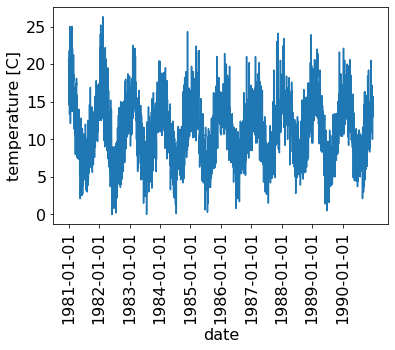

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
matplotlib.rcParams.update({'font.size': 16})

df = pd.read_csv('data/daily-min-temperatures.csv')
print(df.shape)
print(df.head())

plt.plot(df['Temp'])
plt.xticks(np.arange(len(df['Date']))[::365],df['Date'].iloc[::365],rotation=90)
plt.xlabel('date')
plt.ylabel('temperature [C]')
plt.show()


[0.99972603 0.77446147 0.63057611 0.58570362 0.5780733  0.57758888
 0.57542059 0.57472479 0.56812066 0.56190417]


/Users/azsom/opt/anaconda3/envs/data1030/lib/python3.9/site-packages/numpy/lib/function_base.py:2683: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/Users/azsom/opt/anaconda3/envs/data1030/lib/python3.9/site-packages/numpy/lib/function_base.py:2542: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)


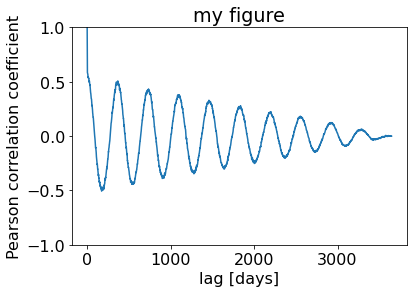

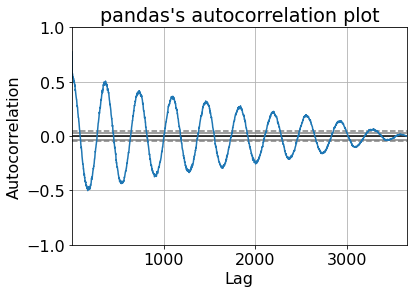

In [12]:
# let's create an autocorrelation plot

lags = np.arange(3650)
corr_coefs = np.zeros(3650)

for i in np.arange(len(lags)):
    x = df['Temp'].iloc[i:-1].reset_index(drop=True) # recent observations
    y = df['Temp'].iloc[:-i-1].reset_index(drop=True) # lag-shifted observations
    # the shapes must be the same
    if x.shape != y.shape:
        raise ValueError('shape mismatch!')
    # Pearson correlation multiplied by the fraction of time series used
    corr_coefs[i] = x.corr(y,method='pearson')*x.shape[0]/df['Temp'].shape[0]
print(corr_coefs[:10])

plt.plot(lags,corr_coefs)
plt.ylim([-1,1])
plt.xlabel('lag [days]')
plt.ylabel('Pearson correlation coefficient')
plt.title('my figure')
plt.show()

# a one-liner
pd.plotting.autocorrelation_plot(df['Temp'])
plt.title("pandas's autocorrelation plot")
plt.show()

# Autoregression: create an iid feature matrix using lag features
- goal:
    - predict what y will be dt in the future
- the target variable and lag features:

| feature_1     | feature_2 	| ... | feature_m-1 | feature m | <font color='red'>target variable</font>|
|-------------	|:------------:	|:---:|:----------:	|:--------:	|:------------:	 |
|     y_0       |    y_1      	| ... | y_m-1   	| y_m	    | <font color='red'>y_m+1</font>|
|     y_1       |    y_2      	| ... | y_m   	    | y_m+1	    | <font color='red'>y_m+2</font>|
|     ...       |    ...      	| ... | ...     	| ...	    | <font color='red'>...</font>  |
|     y_i-m     |    y_i-m+1   	| ... | y_i-2   	| y_i-1	    | <font color='red'>y_i</font>	|
|     ...       |    ...      	| ... | ...     	| ...	    | <font color='red'>...</font>	|
|     y_n-m     |    y_n-m+1   	| ... | y_n-2   	| y_n-1	    | <font color='red'>y_n</font>	|

- the features are shifted with respect to the original observation with a dt lag
- this feature matrix is now iid and can be split with any of the methods we covered in the previous lecture

In [10]:
y = df['Temp']
X = pd.concat([df['Temp'].shift(3),df['Temp'].shift(2),df['Temp'].shift(1)],axis=1)
X.columns = ['lag 3 days','lag 2 days','lag 1 day']
print(X.tail(10))
print(y.tail(10))

      lag 4 days  lag 3 days  lag 2 day
3640        17.2        14.7       15.4
3641        14.7        15.4       13.1
3642        15.4        13.1       13.2
3643        13.1        13.2       13.9
3644        13.2        13.9       10.0
3645        13.9        10.0       12.9
3646        10.0        12.9       14.6
3647        12.9        14.6       14.0
3648        14.6        14.0       13.6
3649        14.0        13.6       13.5
3640    13.2
3641    13.9
3642    10.0
3643    12.9
3644    14.6
3645    14.0
3646    13.6
3647    13.5
3648    15.7
3649    13.0
Name: Temp, dtype: float64


## Things to consider
- lag between the target variable and feature m can be more if you want to predict the observation multiple dt's in the future
- you might also have multiple time series to work with (prices of multiple stock, covid cases in multiple countries, etc)
    - all of those need to be shifted by the same lag relative to the target variable
- due to autocorrelation, the features closer in time to the target variable tend to be more predictive
- how many features should you use?
    - treat the number of features as a hyperparameter

## Special scenarios
- what if dt is not consant and/or each time series have its own non-uniform time?
    - for example you try to predict crypto prices based on stock prices
        - stock prices are available once per hour
        - crypto prices are only available when a trade happens (i.e., some tokens are traded rarely)
- interpolate to a uniform time grid
    - try linear and non-linear interpolation techniques to figure out what works best
    - check out [scipy](https://docs.scipy.org/doc/scipy/reference/tutorial/interpolate.html) for more info
    - cubic spline interpolation usually works well
- you might have a mix of time series and non-time series features
    - cvs customer purchase history
        - you know what a customer bought and when - time series part
        - you have info on the customer (gender, race, address, etc) - non-time series part

## Mud card